# **NLP project. Fake News detection - dataset analysis** 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common as cm
import torch

from transformers import DistilBertTokenizer
from transformers import DistilBertModel

/Users/Kuba/Library/Python/3.9/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [3]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
import re
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download('averaged_perceptron_tagger')
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package wordnet to /Users/Kuba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Kuba/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/Kuba/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Kuba/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
def get_wordnet_pos(tag):
    """
    Map Part-of-Speech (POS) tags to WordNet POS constants.

    Args:
        tag (str): The POS tag (e.g., from nltk.pos_tag) to map to a WordNet POS constant.

    Returns:
        str: The corresponding WordNet POS constant (wordnet.ADJ, wordnet.VERB, wordnet.NOUN, or wordnet.ADV).
        Defaults to wordnet.NOUN if the tag does not match any specific category.
    """
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
def preprocess(text, stop_words, lemmatizer):
    """
    Preprocess a given text by normalizing, tokenizing, removing stop words, and lemmatizing.

    Args:
        text (str): The input text to preprocess.
        stop_words (set): A set of stop words to exclude from the text.
        lemmatizer (WordNetLemmatizer): An instance of WordNetLemmatizer for lemmatizing tokens.

    Returns:
        str: The preprocessed text as a single string.

    Steps:
        1. Convert text to lowercase.
        2. Remove digits from the text.
        3. Tokenize the text into individual words.
        4. Filter out stop words and non-words from the tokens.
        5. Apply part-of-speech tagging and lemmatize each token based on its POS tag.
        6. Join the lemmatized tokens into a single string.
    """
    text = text.lower()
    # remove digits from text
    text = re.sub(r"\d+", "", text)
    word_pattern = re.compile(r"^[^\W\d_]+$", re.UNICODE)

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and word_pattern.match(word)]
    pos_tags = pos_tag(filtered_tokens)
    
    lemms = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

    return " ".join(lemms)

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
true = cm.load_data("True.csv")
true_X = true.drop(columns=['target'])
true_y = true[['target']]

fake = cm.load_data("Fake.csv")
fake_X = fake.drop(columns=['target'])
fake_y = fake[['target']]

X_true_pre, y_true_pre = cm.clean_data(true_X, true_y)
X_fake_pre, y_fake_pre = cm.clean_data(fake_X, fake_y)

X_whole = cm.merge_datasets(X_fake_pre, X_true_pre)
y_whole = cm.merge_datasets(y_fake_pre, y_true_pre)

In [8]:
print(len(fake))
print(len(true))

23481
21417


In [ ]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# # prepocessing articles in collection
# for _, row in X_whole.iterrows():
#     row['text'] = preprocess(row['text'], stop_words, lemmatizer)

# # count vector (term-frequency bag of words) for the whole collection
# CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')
# CountData = CountVec.fit_transform(X_whole['text'])

# # CountData

# # convert to Pandas DataFrame
# df=pd.DataFrame(CountData.toarray(), columns=CountVec.get_feature_names_out())
# df.to_csv('count_data.csv')

In [9]:
count_data = None
chunksize = 1_000 # adjustable
for chunk in pd.read_csv('count_data.csv', chunksize=chunksize, index_col=0):
    if count_data is None:
        count_data = chunk
    else:
        count_data = pd.concat([count_data, chunk], ignore_index=True)
    print(len(count_data))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
44898


## **a) Most frequent words** ##

In [10]:
word_totals = count_data.sum(axis=0)
words_totals_true = count_data[y_whole['target'] == 1].sum(axis=0)
words_totals_fake = count_data[y_whole['target'] == 0].sum(axis=0)

total_terms = count_data.values.sum()
print(f"Total number of terms in the collection: {total_terms}")
print(f"Total number of different terms in the collection: {count_data.shape[1]}")
print()

most_frequent_words = word_totals.sort_values(ascending=False).head(10)
print("Most frequent words across ALL articles:")
print(most_frequent_words)

most_frequent_words_true = words_totals_true.sort_values(ascending=False).head(10)
print("Most frequent words across TRUE articles:")
print(most_frequent_words_true)
print(f"Total number of terms in the TRUE  collection: {total_terms}")
print()

most_frequent_words_fake = words_totals_fake.sort_values(ascending=False).head(10)
print("Most frequent words across FAKE articles:")
print(most_frequent_words_fake)

Total number of terms in the collection: 8860117
Total number of different terms in the collection: 93365

Most frequent words across ALL articles:
say           166729
trump         129178
state          60247
president      53352
people         41324
make           37651
republican     34099
year           33567
new            30273
government     28517
dtype: int64
Most frequent words across TRUE articles:
say           114945
trump          54286
state          36465
president      26935
republican     20268
government     19433
year           18717
house          16939
new            15936
people         15205
dtype: int64
Total number of terms in the TRUE  collection: 8860117

Most frequent words across FAKE articles:
trump        74892
say          51784
president    26417
people       26119
state        23782
make         23304
clinton      18744
like         18400
time         18061
obama        17966
dtype: int64


## **b) Histogram of Term Frequencies** ##

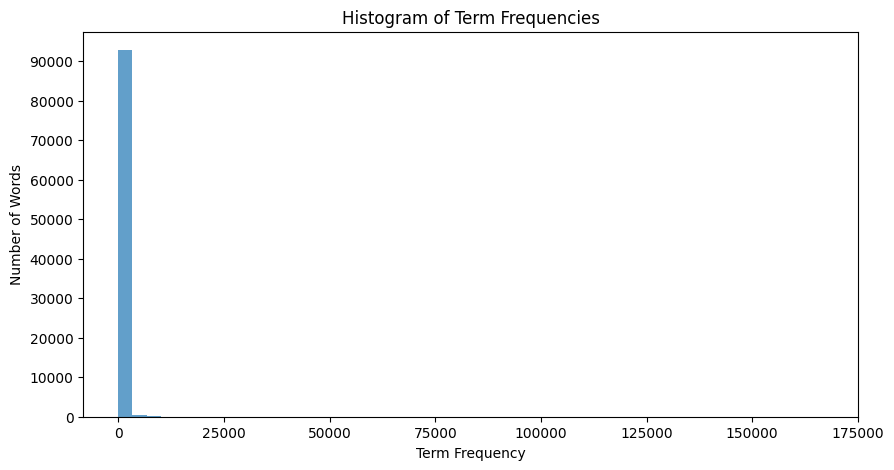

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(word_totals, bins=50, alpha=0.7)
plt.title("Histogram of Term Frequencies")
plt.xlabel("Term Frequency")
plt.ylabel("Number of Words")
plt.yticks(range(0, 95000, 10000))
plt.show()

From this histogram and above analysis we see that most words appear very few times - there are more less 87k (out of 93 000) that appears less than ~150 times — likely just once or twice. This means the vast majority of words appear very few times — likely just once or twice. Then there are few bins of terms that are little common. The long low tail of high frequency words indicates that the number of more frequent words is extrimely low. <br>
To see if our thesis reagarding appearing once or twice is correct lets zoom on x-axis.

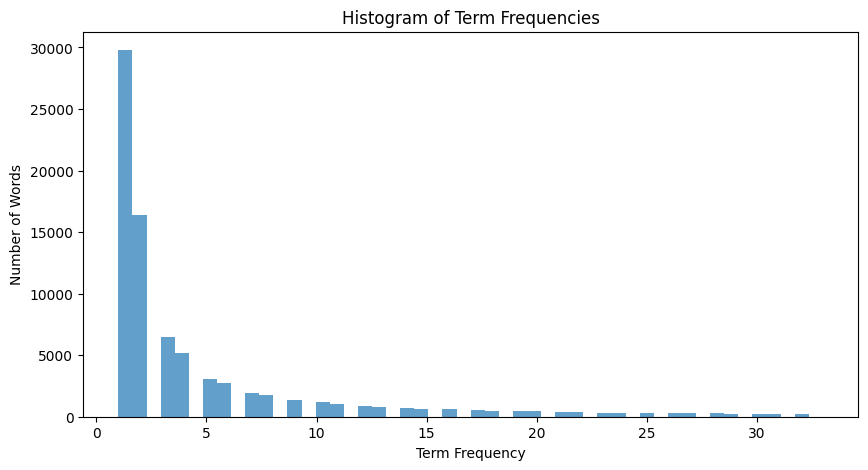

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(word_totals.sort_values().head(80000), bins=50, alpha=0.7)
plt.title("Histogram of Term Frequencies")
plt.xlabel("Term Frequency")
plt.ylabel("Number of Words")
plt.show()

In [13]:
len(word_totals[word_totals < 3])

46202

Now we see 80 000 of the least frequent terms and in fact most of them (about 46k) appears once or twice. That's typical for natural languages.
## **c) Document length distribution**

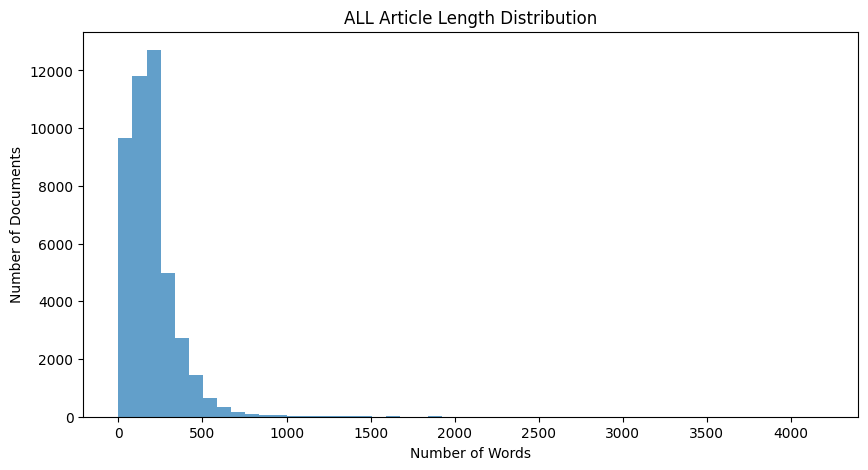

In [14]:
document_lengths = count_data.sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, alpha=0.7)
plt.title("ALL Article Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.xticks(range(0, 4500, 500))
plt.show()

Almost all article are not longer than 500 words. Let's see if there is some significant difference in this distiribution across true or fake articles cases. <br>
We have to remember that those articles were preprocessed (removed stopwords, digits and applied 'only letters' pattern), so originally they were longer.

In [15]:
empty_articles = document_lengths[document_lengths==0]
len(empty_articles)

632

In [16]:
empty_articles

10923    0
11041    0
11190    0
11225    0
11236    0
        ..
21826    0
21827    0
21857    0
21873    0
32451    0
Length: 632, dtype: int64

Unfortunately, 632 articles are empty. However compared to total number of 44k it is only 1.5% of all articles so flitering them out is not a big problem

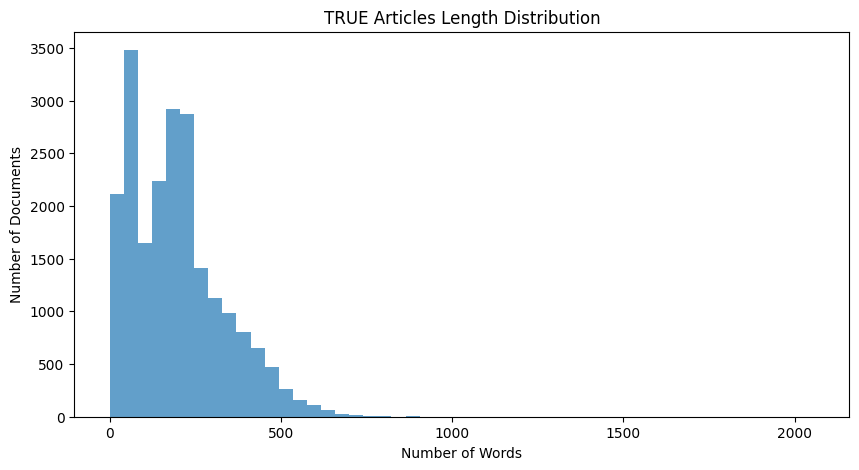

In [17]:
document_lengths = count_data[y_whole['target'] == 1].sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, alpha=0.7)
plt.title("TRUE Articles Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

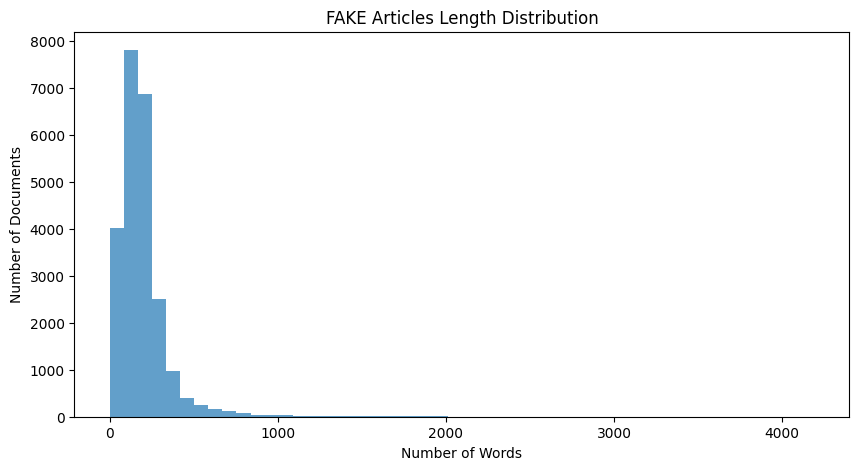

In [18]:
document_lengths = count_data[y_whole['target'] == 0].sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(document_lengths, bins=50, alpha=0.7)
plt.title("FAKE Articles Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.show()

The distributions are rather similar. They more or less ressembles normal distribution with mean around 250 wrods per article. The only difference that can be clearly seen is that there are couple of longer fake articles (more than 1000 words long) and almost no such cases for true articles.
## **d) Similarities between articles**

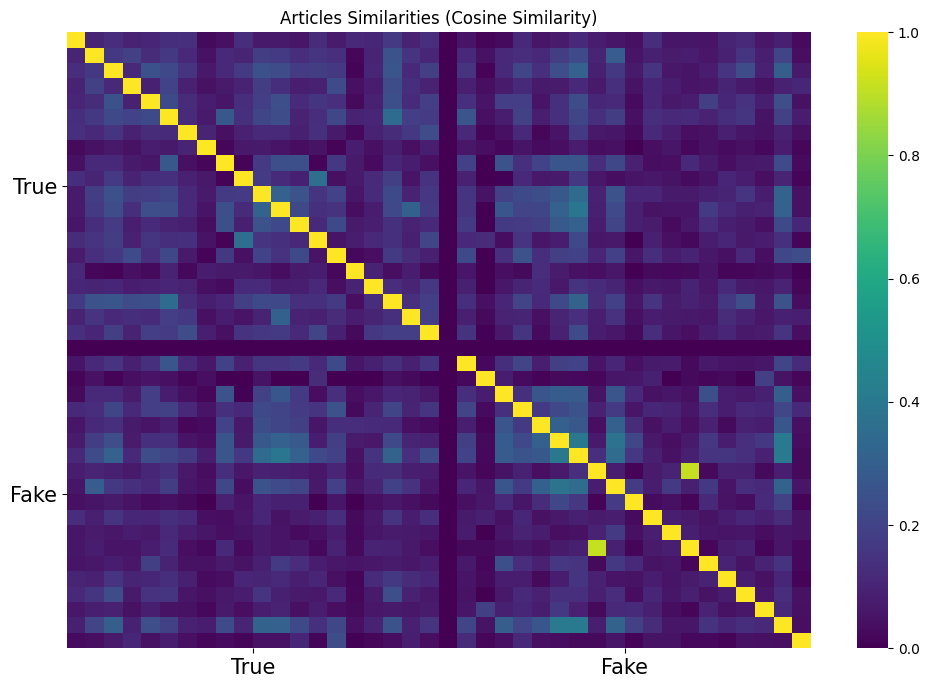

In [19]:
count_data_true = count_data[y_whole['target'] == 1]
count_data_fake = count_data[y_whole['target'] == 0]

true_sample = count_data_true.sample(n=20, random_state=42)
fake_sample = count_data_fake.sample(n=20, random_state=42)

similarity_matrix = cosine_similarity(pd.concat((true_sample, fake_sample)))

plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
plt.xticks([10, 30], ['True', 'Fake'], size=15)
plt.yticks([10, 30], ['True', 'Fake'], size=15)
plt.title("Articles Similarities (Cosine Similarity)")
plt.show()